In [1]:
basepath = '/data/conda/recnn/data'

In [14]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy import interp
import numpy as np
import logging
import pickle
import glob
import sys

np.seterr(divide="ignore")
sys.path.append("..")

from recnn.recnn import grnn_transform_simple
from recnn.recnn import grnn_predict_simple
from recnn.recnn import grnn_predict_gated


from recnn.preprocessing import sequentialize_by_pt
from recnn.preprocessing import rewrite_content
from recnn.preprocessing import multithreadmap
from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import randomize
from recnn.preprocessing import extract




%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 6)

# Loading functions

In [15]:
def extractcontent(jet):
    return(jet["content"])

def tftransform(jet,tf):
    jet["content"] = tf.transform(jet["content"])
    return(jet)

def load_tf(filename_train, preprocess=None, n_events_train=-1):
    # Make training data
    print("Loading training data...")

    X, y = np.load(filename_train)
    X=np.array(X).astype(dict)
    y = np.array(y).astype(int)

    if n_events_train > 0:
        indices = np.random.permutation(len(X))[:n_events_train]
        X = X[indices]
        y = y[indices]

    print("\tfilename = " + filename_train)
    print("\tX size = ")
    print(len(X))
    print("\ty size = ")
    print(len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = multithreadmap(rewrite_content,X)

    if preprocess:
        X = multithreadmap(preprocess,X)

    X = multithreadmap(permute_by_pt,multithreadmap(extract,X))
    Xcontent=multithreadmap(extractcontent,X)
    tf = RobustScaler().fit(np.vstack(Xcontent))

    return(tf)

def load_test(tf, filename_test, preprocess=None):
    # Make test data 
    print("Loading test data...")

    X, y = np.load(filename_test)
    X = np.array(X).astype(dict)
    y = np.array(y).astype(int)

    print("\tfilename = " + filename_test)
    print("\tX size = ")
    print(len(X))
    print("\ty size = ")
    print(len(y))
    # Preprocessing 
    print("Preprocessing...")
    X = multithreadmap(rewrite_content,X)
    
    if preprocess:
        X = multithreadmap(preprocess,X)
        
    X = multithreadmap(permute_by_pt,X)
    X = multithreadmap(extract,X)

    X=multithreadmap(tftransform,X,tf=tf)

    return(X, y)

In [23]:
def predict(X, filename, func=grnn_predict_simple):
    """
    gives the prediction function
    """
    fd = open(filename, "rb")
    params = pickle.load(fd)
    fd.close()
    y_pred = func(params, X)
    return(y_pred)

def evaluate_models(X, y, filename_list, func=grnn_predict_simple):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in filename_list:
        print("Loading " + filename),
            
        y_pred = predict(X, filename, func=func)
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred))
        fpr, tpr, _ = roc_curve(y, y_pred)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
        print("ROC AUC = %.4f" % rocs[-1])
         
    print("Mean ROC AUC = %.4f" % np.mean(rocs))
        
    return(rocs, fprs, tprs)

def build_rocs(trainfile, testfile, model, preprocess=None):
    tf = load_tf(trainfile, preprocess=preprocess)
    X, y = load_test(tf, testfile, preprocess=preprocess) 

    rocs, fprs, tprs = evaluate_models(X, y, [model], func=grnn_predict_gated)
        
    return(rocs, fprs, tprs)

In [24]:
def remove_outliers(rocs, fprs, tprs):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)

    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)

    inv_fprs = np.array(inv_fprs)
    scores = inv_fprs[:, 225]
    
    p25 = np.percentile(scores, 1 / 6. * 100.)
    p75 = np.percentile(scores, 5 / 6. * 100)
    
    robust_mean = np.mean([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])
    robust_std = np.std([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])
    
    indices = [i for i in range(len(scores)) if robust_mean - 3*robust_std <= scores[i] <= robust_mean + 3*robust_std]
    
    new_r, new_f, new_t = [], [], []
    
    for i in indices:
        new_r.append(rocs[i])
        new_f.append(fprs[i])
        new_t.append(tprs[i])
    
    return(new_r, new_f, new_t)


def report_score(rocs, fprs, tprs, label, latex=False, input="particles", short=False):       
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)
    
    if not latex:
        print("%32s\tROC AUC=%.4f+-%.2f\t1/FPR@TPR=0.5=%.2f+-%.2f" %  (label, 
                                                                       np.mean(rocs), 
                                                                       np.std(rocs),
                                                                       np.mean(inv_fprs[:, 225]),
                                                                       np.std(inv_fprs[:, 225])))
    else:
        if not short:
            print("%10s \t& %30s \t& %.4f $\pm$ %.4f \t& %.1f $\pm$ %.1f \\\\" % 
                  (input,
                   label,
                   np.mean(rocs), 
                   np.std(rocs),
                   np.mean(inv_fprs[:, 225]),
                   np.std(inv_fprs[:, 225])))
        else:
            print("%30s \t& %.4f $\pm$ %.4f \t& %.1f $\pm$ %.1f \\\\" % 
                  (label,
                   np.mean(rocs), 
                   np.std(rocs),
                   np.mean(inv_fprs[:, 225]),
                   np.std(inv_fprs[:, 225])))
    return(None)
        
def plot_rocs(rocs, fprs, tprs, label="", color="r", show_all=False):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        if show_all:
            plt.plot(base_tpr, inv_fpr, alpha=0.2, color=color)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)


    plt.plot(base_tpr, mean_inv_fprs, color, 
             label=label)
    return(None)
    
def plot_show(filename=None):
    plt.xlabel("Signal efficiency")
    plt.ylabel("1 / Background efficiency")
    plt.xlim([0.1, 1.0])
    plt.ylim(1, 500)
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

### Counting parameters of the network

In [25]:
modelpath = '/models/model_anti-kt.pickle'

def count(params):
    def _count(thing):
        if isinstance(thing, list):
            c = 0
            for stuff in thing:
                c += _count(stuff)
            return(c) 
        elif isinstance(thing, np.ndarray):
            return(np.prod(thing.shape))
        return(None)

    c = 0
    for k, v in params.items():
        c += _count(v)
    return(c)



fd = open(basepath + modelpath, "rb")
model = pickle.load(fd)
fd.close()

print("number of params = ")
print(count(model))


number of params = 
48761


## Loading data

In [26]:
filename_train = "/npyfiles/MoreStat_anti-kt_train.npy"
filename_test = "/npyfiles/MoreStat_anti-kt_test.npy"
modelpath = "/models/model_anti-kt.pickle"

In [8]:
tf = load_tf(basepath+filename_train)
X, y = load_test(tf, basepath+filename_test)

Loading training data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_anti-kt_train.npy
	X size = 
368696
	y size = 
368696
Preprocessing...
Loading test data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_anti-kt_test.npy
	X size = 
368696
	y size = 
368696
Preprocessing...


In [20]:
fd = open(basepath+modelpath, "rb")
params = pickle.load(fd)
fd.close()

## nice projections

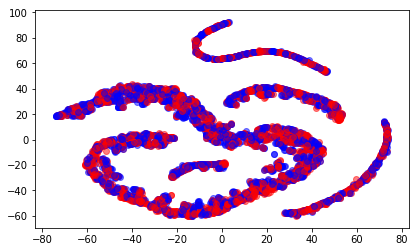

In [10]:
Xt = grnn_transform_simple(params, X[:5000])
Xtt = TSNE(n_components=2).fit_transform(Xt)

fig=plt.figure()
for i in range(5000):
    plt.scatter(Xtt[i, 0], Xtt[i, 1], color="b" if y[i] == 1 else "r", alpha=0.5)

fig.set_size_inches(6.69291,4)
plt.show()

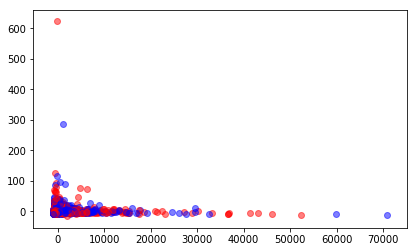

In [11]:
Xtt = PCA(n_components=2).fit_transform(Xt)
fig=plt.figure()

for i in range(5000):
    plt.scatter(Xtt[i, 0], Xtt[i, 1], color="b" if y[i] == 1 else "r", alpha=0.5)
fig.set_size_inches(6.69291,4)
plt.show()

In [28]:
trainfile_list,testfile_list = ['/npyfiles/MoreStat_anti-kt_train.npy'],['/npyfiles/MoreStat_anti-kt_test.npy']
roccurvesfile = "/roccurves/model_anti-kt_roc.pickle"

In [29]:
for i in range(len(trainfile_list)):
    trainfile_list[i]=basepath+trainfile_list[i]

for i in range(len(testfile_list)):
    testfile_list[i]=basepath+testfile_list[i]


for trainfile,testfile in zip(trainfile_list,testfile_list):
    r, f, t = build_rocs(trainfile, testfile,basepath+modelpath)
    
    # Save
    fd = open(basepath+roccurvesfile, "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

Loading training data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_anti-kt_train.npy
	X size = 
368696
	y size = 
368696
Preprocessing...
Loading test data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_anti-kt_test.npy
	X size = 
368696
	y size = 
368696
Preprocessing...
Loading /data/conda/recnn/data/models/model_anti-kt.pickle ROC AUC = 0.5032
Mean ROC AUC = 0.5032


## plots

/roccurves/model_anti-kt_roc.pickle	ROC AUC=0.5032+-0.00	1/FPR@TPR=0.5=2.03+-0.00


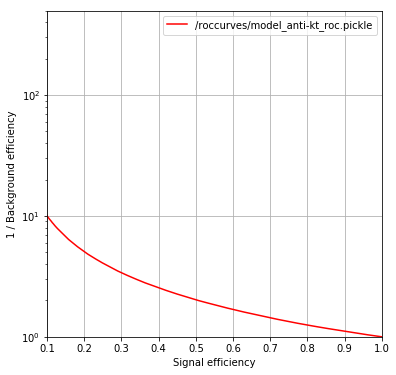

In [31]:
fd = open(basepath+roccurvesfile, "rb")
r, f, t = pickle.load(fd)
fd.close()

r, f, t = remove_outliers(r, f, t)

plot_rocs(r, f, t, label=roccurvesfile)
report_score(r, f, t, label=roccurvesfile)

plot_show()